<a href="https://colab.research.google.com/github/crimson206/example_archive/blob/main/MultiEmbeddingExampleipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch.nn as nn
import torch

import pandas as pd
import numpy as np

# Prepare Data

In [42]:
np.random.seed(0)
n_data = 1080
period = 60

# Generate random data
df = pd.DataFrame({
    'factory_id': np.random.randint(1, 10, n_data),
    'product_id': np.random.randint(1, 100, n_data),
    'temperature': np.random.uniform(20, 30, n_data),
    'humidity': np.random.uniform(30, 70, n_data),
    # Create a repeating sequence with a period of 60
    'time_since_last_maintenance': np.tile(np.arange(period), n_data // period),
    'defect_rate': np.random.uniform(0, 0.1, n_data),
})

df.head()


,factory_id,product_id,temperature,humidity,time_since_last_maintenance,defect_rate
0,6,19,22.274314,43.289493,0,0.063540
1,1,72,28.470173,51.075747,1,0.099109
2,4,61,26.016257,69.309731,2,0.068851
3,4,25,27.532607,35.003351,3,0.053975
4,8,33,22.258089,52.770650,4,0.018211


# Data Processing

In [44]:
def generate_tensor(df):
    categorical_ids = torch.tensor(df[["factory_id", "product_id"]].values)
    continuous_ids = torch.tensor(df[["temperature", "humidity", "defect_rate"]].values).float()
    position_id = torch.tensor(df["time_since_last_maintenance"].values).long()
    return categorical_ids, continuous_ids, position_id

categorical_ids, continuous_ids, position_id = generate_tensor(df)


# Initiate Embedders

In [45]:
categorical_sizes = categorical_ids.max(dim=0)[0] + 1
categorical_emb_dims = [32, 32]

n_continuous = continuous_ids.shape[-1]
continuous_emb = 64

categorical_embedders = [
    nn.Embedding(num_embeddings=categorical_size, embedding_dim=categorical_emb_dim)
    for categorical_size, categorical_emb_dim in zip(categorical_sizes, categorical_emb_dims)
]

continuous_embedder = nn.Linear(n_continuous, continuous_emb)


# Prepare train data

In [46]:
n_seq, d_emb, step = 64, 128, 32

start_idx = 0

categorical_ids_list = []
continuous_ids_list = []
position_id_list = []
tensor_dict = {}

while start_idx+n_seq < n_data:
    end_idx = start_idx+n_seq
    categorical_ids, continuous_ids, position_id = generate_tensor(df.iloc[start_idx:end_idx])
    categorical_ids_list.append(categorical_ids)
    continuous_ids_list.append(continuous_ids)
    position_id_list.append(position_id)
    start_idx += step

tensor_dict["categorical_ids"] = torch.stack(categorical_ids_list)
tensor_dict["continuous_ids"] = torch.stack(continuous_ids_list)
tensor_dict["position_ids"] = torch.stack(position_id_list)


# Convert to Embedding

In [47]:
categorical_embedding = torch.cat(
    [
        embedder(tensor_dict["categorical_ids"][:,:,i])
        for i, embedder in enumerate(categorical_embedders)
    ], dim=-1
)

continuous_embedding = continuous_embedder(tensor_dict["continuous_ids"])

cat_embedding = torch.cat([categorical_embedding, continuous_embedding], dim=2)

cat_embedding.shape


torch.Size([32, 64, 128])

# Arbitrary Position Embedding(optional)

In [ ]:
%%capture
!pip install git+https://github.com/crimson206/DeepLearningDevelopment@0.1.5

In [49]:
from CrimsonDeepLearning.transformers.embeddings import ArbitraryPositionalEncoder

arbitrary_pos_embedder = ArbitraryPositionalEncoder(max_pos_len=1000, d_emb=64)
traditional_pos_embedder = ArbitraryPositionalEncoder(max_pos_len=n_seq, d_emb=64)

In [50]:
arbitrary_distance = tensor_dict["position_ids"]
traditional_distance = torch.arange(0, n_seq).unsqueeze(dim=0).expand(arbitrary_distance.shape)

In [57]:
arbitrary_pos_embedding = arbitrary_pos_embedder.forward(arbitrary_distance)
traditional_pos_embedding = traditional_pos_embedder.forward(traditional_distance)

In [68]:
cat_position_ids = torch.cat([arbitrary_pos_embedding, traditional_pos_embedding], dim=-1)
cat_position_ids.shape

torch.Size([32, 64, 128])

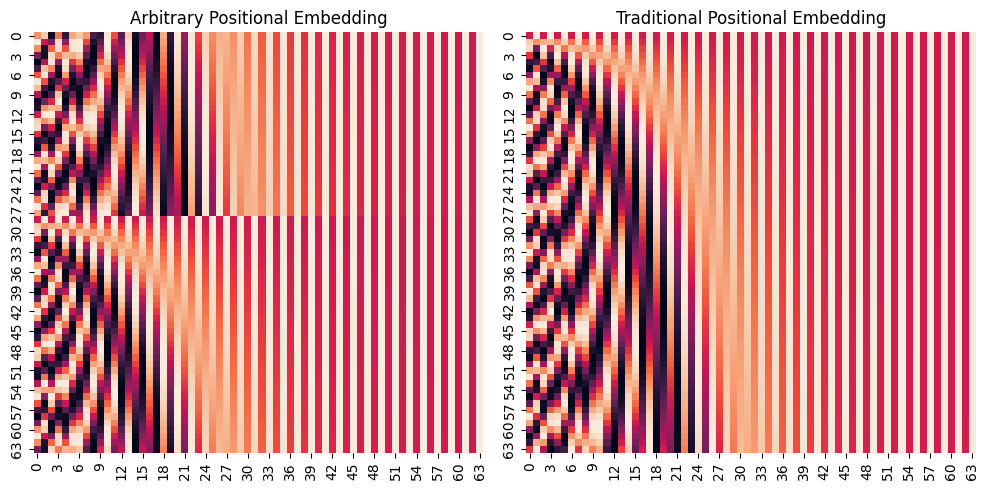

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.heatmap(arbitrary_pos_embedding[1], ax=axes[0], cbar=False)
axes[0].set_title('Arbitrary Positional Embedding')

sns.heatmap(traditional_pos_embedding[1], ax=axes[1], cbar=False)
axes[1].set_title('Traditional Positional Embedding')

plt.tight_layout()
plt.show()


# Final Embedding (optional)

In [70]:
final_embedding = cat_embedding + cat_position_ids
final_embedding.shape

torch.Size([32, 64, 128])